2021-06-16 ~ 2024-03-12


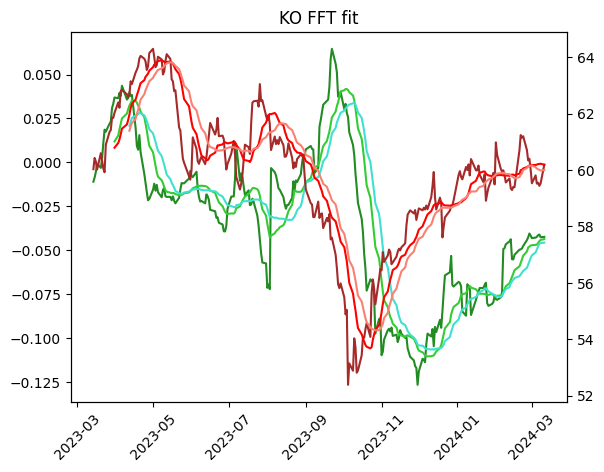

KO 100% with 4 buy orders and 7 sell orders
    type   open_time  open_price  close_time  close_price  profit
0   sell  2023-03-14   60.029999  2023-04-12    62.689999   -4.43
1    buy  2023-04-13   63.150002  2023-04-24    63.950001    1.27
2   sell  2023-04-25   63.849998  2023-06-01    60.000000    6.03
3   sell  2023-06-20   61.259998  2023-07-12    59.840000    2.32
4    buy  2023-07-24   62.459999  2023-07-27    62.439999   -0.03
5   sell  2023-07-28   62.480000  2023-08-16    60.480000    3.20
6   sell  2023-09-01   59.310001  2023-09-05    58.820000    0.83
7   sell  2023-10-11   53.709999  2023-12-18    59.020000   -9.89
8    buy  2023-12-19   58.830002  2024-01-18    60.160000    2.26
9   sell  2024-01-19   59.830002  2024-02-02    60.540001   -1.19
10   buy  2024-02-13   59.349998  2024-03-11    60.190201    1.42


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import sin, cos, sqrt, exp
import yfinance as yf
from datetime import datetime, timedelta
def trigfit(x, n, w, m, a, b, xm):
    Sc =0.0
    Ss =0.0
    Scc=0.0
    Sss=0.0
    Scs=0.0
    Sx =0.0
    Sxc=0.0
    Sxs=0.0
    for i in range(n):
        c = cos(w*i)
        s = sin(w*i)
        dx = x[i] - xm[i]
        Sc +=c
        Ss +=s
        Scc+=c*c
        Sss+=s*s
        Scs+=c*s
        Sx +=dx
        Sxc+=dx*c
        Sxs+=dx*s
    Sc /=n
    Ss /=n
    Scc/=n
    Sss/=n
    Scs/=n
    Sx /=n
    Sxc/=n
    Sxs/=n   
    if w == 0 or None:
        m = Sx
        a = 0.0
        b = 0.0
    else:
        den=(Scs-Sc*Ss)**2-(Scc-Sc*Sc)*(Sss-Ss*Ss)
        a=((Sxs-Sx*Ss)*(Scs-Sc*Ss)-(Sxc-Sx*Sc)*(Sss-Ss*Ss))/den
        b=((Sxc-Sx*Sc)*(Scs-Sc*Ss)-(Sxs-Sx*Ss)*(Scc-Sc*Sc))/den
        m=Sx-a*Sc-b*Ss
    return w, m, a ,b 
def freq(x, n, w, m, a, b, xm):
    FreqTOL =0.00009 # 0.00001
    z = [None] * n
    alpha = 0.0 # = beta for initialization
    beta = 2.0
    z[0] = x[0] - xm[0]
    while abs(alpha - beta) > FreqTOL:
        alpha = beta
        z[1] = x[1] - xm[1] + alpha * z[0]
        num = z[0] * z[1]
        den = z[0] * z[0]
        for i in range(2, n):
            z[i] = x[i] - xm[i] + alpha*z[i-1] - z[i-2]
            num += z[i-1]*(z[i]+z[i-2])
            den+=z[i-1]*z[i-1]
        beta = num/den
    if -1 <= beta/2.0 <= 1:
        w = np.arccos(beta/2.0)
    else:
        w= 0 
    w, m, a, b = trigfit(x, n, w, m, a, b, xm)
    return w, m, a, b
def main_v2(ticker, close, day):
    start =  datetime.now()- timedelta(days=1000)
    end = datetime.now() - timedelta(days=day)
    # print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
    # shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
    av = 0.0

    past = 300
    pred = 100
    # past closed price
    x = [None] * 300

    # average price for the past 300(past) days
    xm = [None] * 300
    ym = [None] * 101
    # print(len(x), len(close))
    for i in range(past):
        x[i] = list(close)[i]
        av += x[i]
    av/=past

    for i in range(past):
        xm[i] = av
        if(i <= pred):
            ym[i] = av
    harmonics = 20
    w = 0.0
    m = 0.0
    a = 0.0
    b = 0.0
    for i in range(1, harmonics + 1):
        w, m, a, b = freq(x, past, w, m, a, b, xm)
        for i in range(past):
            xm[i] += m+a*cos(w*i) + b*sin(w*i)
            if(i <= pred):
                ym[i] += m+a*cos(w*i)-b*sin(w*i)
    return ym


def get_signal(df):
    if df["EMA1"] - df['EMA2'] > 0:
# df['linreg'] > 0.2
        return 1
    else:
        return 0
def main_v3(day=200, test_len=200, ticker="NVDA", ma1=14, ma2=28):
    start =  datetime.now()- timedelta(days=1000+day)
    end = datetime.now() - timedelta(days=day)
    print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
    shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
    close = shop['Close']
    linregress_array = [None] * test_len

    for i in range(test_len):
        # 1/30 => 1/29 => 1/28 => ...
        close1 = close[::-1][i:i+300]
        a = main_v2(ticker, close1, 0)
        r = np.polyfit(np.arange(0, len(a), 1), a, 1)[0]
        linregress_array[i] = r
        # print(r)
    show = [i if i != 0 else 1 for i in linregress_array]
    # ma1 = 14
    # ma2 = 28
    # print(linregress_array)
    fig, ax1 = plt.subplots()
    df = pd.DataFrame({'close':close[-test_len:], 'linreg':show[::-1]}, index=close.index[-test_len:])
    df[f'EMA1'] = df['linreg'].rolling(ma1).mean()
    df[f'EMA2'] = df['linreg'].rolling(ma2).mean()
    df["CLMA1"] = df['close'].rolling(ma1).mean()
    df["CLMA2"] = df['close'].rolling(ma2).mean()
    df['Signal'] = df.apply(get_signal, axis=1)
    ax2 = ax1.twinx()
    ax1.plot(close.index[-test_len:], df['linreg'], 'forestgreen', label='linreg')
    ax1.plot(close.index[-test_len:], df[f'EMA1'], 'limegreen', label=f'linreg{ma1}')
    ax1.plot(close.index[-test_len:], df[f'EMA2'], 'turquoise', label=f'linreg{ma2}')
    ax2.plot(close.index[-test_len:], close[-test_len:], 'brown', label='close')
    ax2.plot(close.index[-test_len:], df['CLMA1'], 'red', label=f'close{ma1}')
    ax2.plot(close.index[-test_len:], df["CLMA2"], 'salmon', label=f'close{ma2}')
    ax1.tick_params(axis='x', rotation=45)
    plt.title(f"{ticker} FFT fit")
    # ax1.legend(loc=1)
    # ax2.legend(loc=2)
    plt.show()
    res = backtest_manual(df, ticker)
    return res
   

def backtest_manual(df, ticker):
    log_profit = 1
    order = None
    orders_buy = 0
    orders_sell = 0
    df_output = []
    df_temp_output = []
    for i in range(len(df['Signal'])):
        if (list(df['Signal'])[i] == 1 and order == None):
            if (list(df['CLMA1'])[i] > list(df["CLMA2"])[i]):
                open_price = list(df['close'])[i]
                order = "buy"
                df_temp_output.append(order)
                df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
                df_temp_output.append(open_price)
        elif (list(df['Signal'])[i] == 0 and order == "buy"):
            #  or (list(df['CLMA1'])[i] < list(df["CLMA2"])[i])
            close_price = list(df['close'])[i]
            profit = (close_price - open_price)/open_price
            log_profit *= (1+profit)
            order = None
            orders_buy += 1
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(close_price)
            df_temp_output.append(round(profit*100, 2))
            df_output.append(df_temp_output)
            df_temp_output = []
        # sell position or not
        elif list(df['Signal'])[i] == 0 and order == None:
            open_price = list(df['close'])[i]
            order = 'sell'
            df_temp_output.append(order)
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(open_price)
        elif list(df['Signal'])[i] == 1 and order == 'sell':
            close_price = list(df['close'])[i]
            profit = -(close_price - open_price)/open_price
            log_profit *= (1+profit)
            order = None
            orders_sell += 1
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(close_price)
            df_temp_output.append(round(profit*100, 2))
            df_output.append(df_temp_output)
            df_temp_output = []
    if order == 'buy' or order == 'sell':
        close_price = list(df['close'])[-1]
        if order == 'sell':
            profit = -(close_price - open_price)/open_price
            log_profit *= (1+profit)
            orders_sell += 1
        elif order == 'buy':
            profit = (close_price - open_price)/open_price
            log_profit *= (1+profit)
            orders_buy += 1
        df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        df_temp_output.append(close_price)
        df_temp_output.append(round(profit*100, 2))
        df_output.append(df_temp_output)
        df_temp_output = []
        order = None
    print(f"{ticker} {int(log_profit*100)}% with {orders_buy} buy orders and {orders_sell} sell orders")
    df_final = pd.DataFrame(df_output, columns=['type', 'open_time', 'open_price', 'close_time', 'close_price', 'profit'])
    return df_final
    # EB
take = ["OGN", "FFIN", "CE", "AMZN", "MSFT", "PANL", "SHLS", "CDNS", "ATRA", "BRBR", "EYPT", 'CABA', "VERI", 'TXT', "IBKR", "PSTX", "RPD", "MORF", "AER", "SPR", "EPC"]
takes = ["KO", "C", "LLY", "NVO", "BNTX", "ENIC"]
takes = ["ETR", "BMY", "VICI", "SNY", "UTHR", "CVS", "ACI", "PEG", "GSK", "MO", "BG", "BNTX"]
ax1 = ["CIG"]

for i in ["KO"]:
    print(main_v3(day=0, test_len=250, ticker=i, ma1=14, ma2=21))

2021-06-16 ~ 2024-03-12


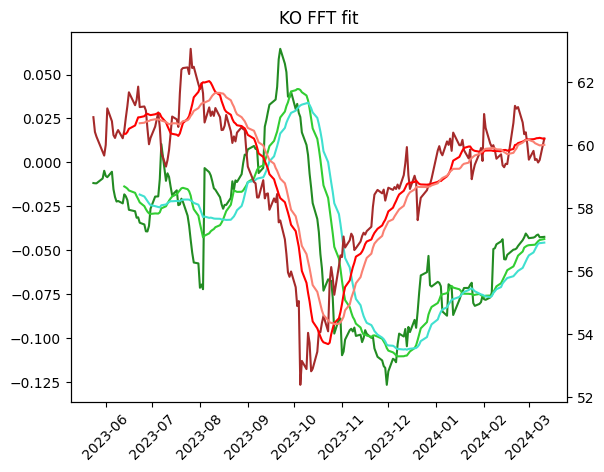

KO 97% with 3 buy orders and 5 sell orders
   type   open_time  open_price  close_time  close_price  profit
0  sell  2023-05-24   60.880001  2023-07-12    59.840000    1.71
1   buy  2023-07-24   62.459999  2023-07-27    62.439999   -0.03
2  sell  2023-07-28   62.480000  2023-08-16    60.480000    3.20
3  sell  2023-09-01   59.310001  2023-09-05    58.820000    0.83
4  sell  2023-10-11   53.709999  2023-12-18    59.020000   -9.89
5   buy  2023-12-19   58.830002  2024-01-18    60.160000    2.26
6  sell  2024-01-19   59.830002  2024-02-02    60.540001   -1.19
7   buy  2024-02-13   59.349998  2024-03-11    60.205002    1.44


In [3]:
print(main_v3(day=0, test_len=200, ticker=i, ma1=14, ma2=21))

2020-11-14 ~ 2023-08-11


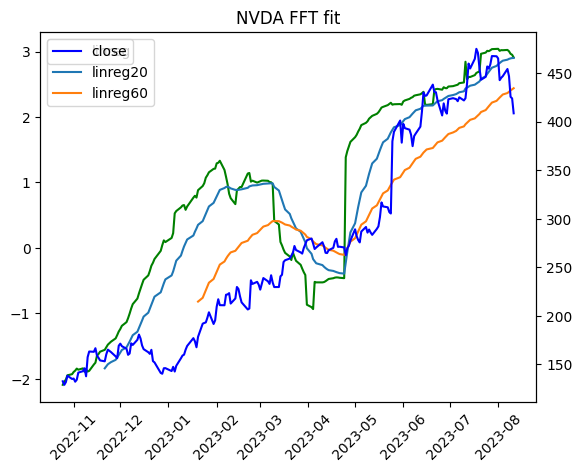

NVDA 129% with 2 buy orders and 2 sell orders


,type,open_time,open_price,close_time,close_price,profit
0,sell,2022-10-25,132.610001,2023-01-20,178.389999,-34.52
1,buy,2023-01-23,191.929993,2023-03-27,265.309998,38.23
2,sell,2023-03-28,264.100006,2023-04-27,272.260010,-3.09
3,buy,2023-04-28,277.489990,2023-08-11,408.549988,47.23


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import sin, cos, sqrt, exp
import yfinance as yf
from datetime import datetime, timedelta
import pandas_ta as ta
def trigfit(x, n, w, m, a, b, xm):
    Sc =0.0
    Ss =0.0
    Scc=0.0
    Sss=0.0
    Scs=0.0
    Sx =0.0
    Sxc=0.0
    Sxs=0.0
    for i in range(n):
        c = cos(w*i)
        s = sin(w*i)
        dx = x[i] - xm[i]
        Sc +=c
        Ss +=s
        Scc+=c*c
        Sss+=s*s
        Scs+=c*s
        Sx +=dx
        Sxc+=dx*c
        Sxs+=dx*s
    Sc /=n
    Ss /=n
    Scc/=n
    Sss/=n
    Scs/=n
    Sx /=n
    Sxc/=n
    Sxs/=n   
    if w == 0 or None:
        m = Sx
        a = 0.0
        b = 0.0
    else:
        den=(Scs-Sc*Ss)**2-(Scc-Sc*Sc)*(Sss-Ss*Ss)
        a=((Sxs-Sx*Ss)*(Scs-Sc*Ss)-(Sxc-Sx*Sc)*(Sss-Ss*Ss))/den
        b=((Sxc-Sx*Sc)*(Scs-Sc*Ss)-(Sxs-Sx*Ss)*(Scc-Sc*Sc))/den
        m=Sx-a*Sc-b*Ss
    return w, m, a ,b 
def freq(x, n, w, m, a, b, xm):
    FreqTOL =0.00009 # 0.00001
    z = [None] * n
    alpha = 0.0 # = beta for initialization
    beta = 2.0
    z[0] = x[0] - xm[0]
    while abs(alpha - beta) > FreqTOL:
        alpha = beta
        z[1] = x[1] = xm[1] + alpha * z[0]
        num = z[0] * z[1]
        den = z[0] * z[0]
        for i in range(2, n):
            z[i] = x[i] - xm[i] + alpha*z[i-1] - z[i-2]
            num += z[i-1]*(z[i]+z[i-2])
            den+=z[i-1]*z[i-1]
        beta = num/den
    if -1 <= beta/2.0 <= 1:
        w = np.arccos(beta/2.0)
    else:
        w= 0 
    w, m, a, b = trigfit(x, n, w, m, a, b, xm)
    return w, m, a, b
# def main_v2(ticker, close, day):
#     start =  datetime.now()- timedelta(days=1000)
#     end = datetime.now() - timedelta(days=day)
#     # print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
#     # shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
#     av = 0.0

#     past = 300
#     pred = 100
#     # past closed price
#     x = [None] * 300

#     # average price for the past 300(past) days
#     xm = [None] * 300
#     ym = [None] * 101
#     # print(len(x), len(close))
#     for i in range(past):
#         x[i] = close[i]
#         av += x[i]
#     av/=past

#     for i in range(past):
#         xm[i] = av
#         if(i <= pred):
#             ym[i] = av
#     harmonics = 20
#     w = 0.0
#     m = 0.0
#     a = 0.0
#     b = 0.0
#     for i in range(1, harmonics + 1):
#         w, m, a, b = freq(x, past, w, m, a, b, xm)
#         for i in range(past):
#             xm[i] += m+a*cos(w*i) + b*sin(w*i)
#             if(i <= pred):
#                 ym[i] += m+a*cos(w*i)-b*sin(w*i)
#     return ym


def get_signal(df):
    if df["EMA_20"] - df["EMA_60"] > 0:
# df['linreg'] > 0.2
        return 1
    else:
        return 0
def main_v3(day=200, test_len=200, ticker="NVDA"):
    start =  datetime.now()- timedelta(days=1000+day)
    end = datetime.now() - timedelta(days=day)
    print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
    shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
    close = shop['Close']
    linregress_array = [None] * test_len

    for i in range(test_len):
        # 1/30 => 1/29 => 1/28 => ...
        close1 = close[::-1][i:i+300]
        a = main_v2(ticker, close1, 0)
        r = np.polyfit(np.arange(0, len(a), 1), a, 1)[0]
        linregress_array[i] = r

    show = [i if i != 0 else 1 for i in linregress_array]
    ma1 = 20
    ma2 = 60
    # print(linregress_array)
    fig, ax1 = plt.subplots()
    df = pd.DataFrame({'close':close[-test_len:], 'linreg':show[::-1]}, index=close.index[-test_len:])
    df.ta.ema(close='linreg', length=ma1, append=True)
    df.ta.ema(close='linreg', length=ma2, append=True)
    df['Signal'] = df.apply(get_signal, axis=1)
    ax2 = ax1.twinx()
    ax1.plot(close.index[-test_len:], show[::-1], 'g-', label='linreg')
    ax1.plot(close.index[-test_len:], df[f'EMA_{ma1}'], label=f'linreg{ma1}')
    ax1.plot(close.index[-test_len:], df[f'EMA_{ma2}'], label=f'linreg{ma2}')
    ax2.plot(close.index[-test_len:], close[-test_len:], 'b-', label='close')
    ax1.tick_params(axis='x', rotation=45)
    plt.title(f"{ticker} FFT fit")
    ax1.legend()
    ax2.legend()
    plt.show()
    res = backtest_manual(df, ticker)
    return res
   

def backtest_manual(df, ticker):
    log_profit = 1
    order = None
    orders_buy = 0
    orders_sell = 0
    df_output = []
    df_temp_output = []
    for i in range(len(df['Signal'])):
        if df['Signal'][i] == 1 and order == None:
            open_price = df['close'][i]
            order = "buy"
            df_temp_output.append(order)
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(open_price)
        elif df['Signal'][i] == 0 and order == "buy":
            close_price = df['close'][i]
            profit = (close_price - open_price)/open_price
            log_profit *= (1+profit)
            order = None
            orders_buy += 1
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(close_price)
            df_temp_output.append(round(profit*100, 2))
            df_output.append(df_temp_output)
            df_temp_output = []
        elif df['Signal'][i] == 0 and order == None:
            open_price = df['close'][i]
            order = 'sell'
            df_temp_output.append(order)
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(open_price)
        elif df['Signal'][i] == 1 and order == 'sell':
            close_price = df['close'][i]
            profit = -(close_price - open_price)/open_price
            log_profit *= (1+profit)
            order = None
            orders_sell += 1
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(close_price)
            df_temp_output.append(round(profit*100, 2))
            df_output.append(df_temp_output)
            df_temp_output = []
    if order == 'buy' or order == 'sell':
        close_price = df['close'][-1]
        if order == 'sell':
            profit = -(close_price - open_price)/open_price
            log_profit *= (1+profit)
            orders_sell += 1
        elif order == 'buy':
            profit = (close_price - open_price)/open_price
            log_profit *= (1+profit)
            orders_buy += 1
        df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        df_temp_output.append(close_price)
        df_temp_output.append(round(profit*100, 2))
        df_output.append(df_temp_output)
        df_temp_output = []
        order = None
    print(f"{ticker} {int(log_profit*100)}% with {orders_buy} buy orders and {orders_sell} sell orders")
    df_final = pd.DataFrame(df_output, columns=['type', 'open_time', 'open_price', 'close_time', 'close_price', 'profit'])
    return df_final
main_v3(day=200, test_len=200, ticker="NVAX")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import sin, cos, sqrt, exp
import yfinance as yf
from datetime import datetime, timedelta
import pandas_ta as ta
def trigfit(x, n, w, m, a, b, xm):
    Sc =0.0
    Ss =0.0
    Scc=0.0
    Sss=0.0
    Scs=0.0
    Sx =0.0
    Sxc=0.0
    Sxs=0.0
    for i in range(n):
        c = cos(w*i)
        s = sin(w*i)
        dx = x[i] - xm[i]
        Sc +=c
        Ss +=s
        Scc+=c*c
        Sss+=s*s
        Scs+=c*s
        Sx +=dx
        Sxc+=dx*c
        Sxs+=dx*s
    Sc /=n
    Ss /=n
    Scc/=n
    Sss/=n
    Scs/=n
    Sx /=n
    Sxc/=n
    Sxs/=n   
    if w == 0 or None:
        m = Sx
        a = 0.0
        b = 0.0
    else:
        den=(Scs-Sc*Ss)**2-(Scc-Sc*Sc)*(Sss-Ss*Ss)
        a=((Sxs-Sx*Ss)*(Scs-Sc*Ss)-(Sxc-Sx*Sc)*(Sss-Ss*Ss))/den
        b=((Sxc-Sx*Sc)*(Scs-Sc*Ss)-(Sxs-Sx*Ss)*(Scc-Sc*Sc))/den
        m=Sx-a*Sc-b*Ss
    return w, m, a ,b 
def freq(x, n, w, m, a, b, xm):
    FreqTOL =0.00009 # 0.00001
    z = [None] * n
    alpha = 0.0 # = beta for initialization
    beta = 2.0
    z[0] = x[0] - xm[0]
    while abs(alpha - beta) > FreqTOL:
        alpha = beta
        z[1] = x[1] = xm[1] + alpha * z[0]
        num = z[0] * z[1]
        den = z[0] * z[0]
        for i in range(2, n):
            z[i] = x[i] - xm[i] + alpha*z[i-1] - z[i-2]
            num += z[i-1]*(z[i]+z[i-2])
            den+=z[i-1]*z[i-1]
        beta = num/den
    if -1 <= beta/2.0 <= 1:
        w = np.arccos(beta/2.0)
    else:
        w= 0 
    w, m, a, b = trigfit(x, n, w, m, a, b, xm)
    return w, m, a, b
def main_v2(ticker, close, day):
    start =  datetime.now()- timedelta(days=1000)
    end = datetime.now() - timedelta(days=day)
    # print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
    # shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
    av = 0.0

    past = 300
    pred = 100
    # past closed price
    x = [None] * 300

    # average price for the past 300(past) days
    xm = [None] * 300
    ym = [None] * 101
    # print(len(x), len(close))
    for i in range(past):
        x[i] = close[i]
        av += x[i]
    av/=past

    for i in range(past):
        xm[i] = av
        if(i <= pred):
            ym[i] = av
    harmonics = 20
    w = 0.0
    m = 0.0
    a = 0.0
    b = 0.0
    for i in range(1, harmonics + 1):
        w, m, a, b = freq(x, past, w, m, a, b, xm)
        for i in range(past):
            xm[i] += m+a*cos(w*i) + b*sin(w*i)
            if(i <= pred):
                ym[i] += m+a*cos(w*i)-b*sin(w*i)
    return ym


def get_signal(df):
    if df["EMA_20"] - df["EMA_60"] > 0:
# df['linreg'] > 0.2
        return 1
    else:
        return 0
def main_v3(day=200, test_len=200, ticker="NVDA"):
    start =  datetime.now()- timedelta(days=1000+day)
    end = datetime.now() - timedelta(days=day)
    print(start.strftime("%Y-%m-%d"), "~", end.strftime("%Y-%m-%d"))
    shop = yf.download(ticker, start= start, end = end, interval = "1d", progress=False)
    close = shop['Close']
    linregress_array = [None] * test_len

    for i in range(test_len):
        # 1/30 => 1/29 => 1/28 => ...
        close1 = close[::-1][i:i+300]
        a = main_v2(ticker, close1, 0)
        r = np.polyfit(np.arange(0, len(a), 1), a, 1)[0]
        linregress_array[i] = r

    show = [i if i != 0 else 1 for i in linregress_array]
    ma1 = 20
    ma2 = 60
    # print(linregress_array)
    fig, ax1 = plt.subplots()
    df = pd.DataFrame({'close':close[-test_len:], 'linreg':show[::-1]}, index=close.index[-test_len:])
    df.ta.ema(close='linreg', length=ma1, append=True)
    df.ta.ema(close='linreg', length=ma2, append=True)
    df['Signal'] = df.apply(get_signal, axis=1)
    ax2 = ax1.twinx()
    ax1.plot(close.index[-test_len:], show[::-1], 'g-', label='linreg')
    ax1.plot(close.index[-test_len:], df[f'EMA_{ma1}'], label=f'linreg{ma1}')
    ax1.plot(close.index[-test_len:], df[f'EMA_{ma2}'], label=f'linreg{ma2}')
    ax2.plot(close.index[-test_len:], close[-test_len:], 'b-', label='close')
    ax1.tick_params(axis='x', rotation=45)
    plt.title(f"{ticker} FFT fit")
    ax1.legend()
    ax2.legend()
    plt.show()
    res = backtest_manual(df, ticker)
    return res
   

def backtest_manual(df, ticker):
    log_profit = 1
    order = None
    orders_buy = 0
    orders_sell = 0
    df_output = []
    df_temp_output = []
    for i in range(len(df['Signal'])):
        if df['Signal'][i] == 1 and order == None:
            open_price = df['close'][i]
            order = "buy"
            df_temp_output.append(order)
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(open_price)
        elif df['Signal'][i] == 0 and order == "buy":
            close_price = df['close'][i]
            profit = (close_price - open_price)/open_price
            log_profit *= (1+profit)
            order = None
            orders_buy += 1
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(close_price)
            df_temp_output.append(round(profit*100, 2))
            df_output.append(df_temp_output)
            df_temp_output = []
        elif df['Signal'][i] == 0 and order == None:
            open_price = df['close'][i]
            order = 'sell'
            df_temp_output.append(order)
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(open_price)
        elif df['Signal'][i] == 1 and order == 'sell':
            close_price = df['close'][i]
            profit = -(close_price - open_price)/open_price
            log_profit *= (1+profit)
            order = None
            orders_sell += 1
            df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
            df_temp_output.append(close_price)
            df_temp_output.append(round(profit*100, 2))
            df_output.append(df_temp_output)
            df_temp_output = []
    if order == 'buy' or order == 'sell':
        close_price = df['close'][-1]
        if order == 'sell':
            profit = -(close_price - open_price)/open_price
            log_profit *= (1+profit)
            orders_sell += 1
        elif order == 'buy':
            profit = (close_price - open_price)/open_price
            log_profit *= (1+profit)
            orders_buy += 1
        df_temp_output.append(list(df.index)[i].strftime("%Y-%m-%d"))
        df_temp_output.append(close_price)
        df_temp_output.append(round(profit*100, 2))
        df_output.append(df_temp_output)
        df_temp_output = []
        order = None
    print(f"{ticker} {int(log_profit*100)}% with {orders_buy} buy orders and {orders_sell} sell orders")
    df_final = pd.DataFrame(df_output, columns=['type', 'open_time', 'open_price', 'close_time', 'close_price', 'profit'])
    return df_final
main_v3(day=200, test_len=200, ticker="KO")

ModuleNotFoundError: No module named 'pkg_resources'